# Problem statement
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, we will analyze customer-level data of a telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.


todo EDA:
- total charges depending on tenure? is it leaking?
- Better visualisation for all feature distributions
- To include non-numeric columns in the correlation matrix, you can encode them as numeric variables using techniques such as one-hot encoding or label encoding.

todo pre processing:
- SMOTE sample

In [176]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set display options for data exploratory analysis
pd.set_option('display.max_columns', None)


In [177]:
# Read data
df = pd.read_csv('churn_initial_df.csv')

In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [179]:
# Print all unique values for each column
for column in df.columns:
    unique_values = df[column].unique()
    print(f"{column}: {unique_values}")

customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)

In [180]:
# There are some columns that are supposed to have categorical values only,
#   but include more. We need to correct them.

# replace 'No internet service' with NaN values
df.replace('No internet service', np.nan, inplace=True)

# create a new column 'Has_Internet_Service' which has a value of 1 if any of the columns in a row have a non-NaN value
df['Has_Internet_Service'] = df[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']].notnull().any(axis=1).astype(int)

# replace 'Yes' with 1 and 'No' with 0
df.replace(['Yes', 'No'], [1, 0], inplace=True)

# fill NaN values with 0s for the new columns
df[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']] = df[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']].fillna(0).astype('int64')


In [181]:
# Replace Yes, No with 1,0 in all columns where there is
#    only Yes, No values

# Loop through each column
for col in df.columns:
    # Check if column has only 'Yes' and 'No' values
    if set(df[col].unique()) == set(['Yes', 'No']):
        # Replace 'Yes' with 1 and 'No' with 0
        df[col] = df[col].map({'Yes': 1, 'No': 0})

In [182]:
# Define list of columns to convert
cols_to_convert = ['TotalCharges']

# Loop through each column and convert to float
for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Print data types of all columns
print(df.dtypes)

customerID               object
gender                   object
SeniorCitizen             int64
Partner                   int64
Dependents                int64
tenure                    int64
PhoneService              int64
MultipleLines            object
InternetService          object
OnlineSecurity            int64
OnlineBackup              int64
DeviceProtection          int64
TechSupport               int64
StreamingTV               int64
StreamingMovies           int64
Contract                 object
PaperlessBilling          int64
PaymentMethod            object
MonthlyCharges          float64
TotalCharges            float64
Churn                     int64
Has_Internet_Service      int64
dtype: object


In [183]:
def check_for_duplicates(df):
    """Checks for duplicate values in a given dataframe."""
    if df.duplicated().any().any():
        # if any duplicated values exist, print a message indicating their presence
        print("- There are duplicated values in the dataframe.")
    else:
        # if no duplicated values exist, print a message indicating their absence
        print("- There are no duplicated values in the dataframe.")


def check_for_missing_values(df):
    """Checks for missing values in a given dataframe."""
    if df.isnull().any().any():
        # create a list of columns with missing values
        null_cols = df.columns[df.isnull().any()].tolist()
        for col in null_cols:
            # for each column with missing values, print a message indicating their presence
            print(f"- There are missing values in the dataframe. Column '{col}' has missing values.")
    else:
        # if no missing values exist, print a message indicating their absence
        print("- There are no missing values in the dataframe.")


def check_for_imbalanced_dataset(df):
    """Checks for class imbalance in a given dataframe."""
    # count the number of samples in each class
    class_counts = df['Churn'].value_counts()

    # calculate the imbalance ratio
    imbalance_ratio = class_counts.min() / class_counts.sum()

    if imbalance_ratio < 0.3:
        # if the imbalance ratio is below a threshold, print a message indicating class imbalance
        print(f"- The dataframe is imbalanced, with an imbalance ratio of {round(imbalance_ratio, 2)}.")
    else:
        # if the imbalance ratio is above a threshold, print a message indicating class balance
        print(f"- The dataframe is balanced, with an imbalance ratio of {round(imbalance_ratio, 2)}.")


# Apply functions
check_for_duplicates(df)
check_for_missing_values(df)
check_for_imbalanced_dataset(df)


- There are no duplicated values in the dataframe.
- There are missing values in the dataframe. Column 'TotalCharges' has missing values.
- The dataframe is imbalanced, with an imbalance ratio of 0.27.


In [184]:
# Drop NaN values in TotalCharges
df.dropna(subset=['TotalCharges'], inplace=True)

In [185]:
# Convert categorical variables to binary using one-hot encoding
#    The resulting dummy variables are added to the DataFrame as new columns
df = pd.get_dummies(df, columns=["gender", "Contract", "InternetService", "PaymentMethod", "MultipleLines"])


It is generally a good practice to scale or normalize your data before using it for model training with XGBoost. The main reason for doing this is to ensure that all features contribute equally to the model and to avoid the domination of certain features over others.

For example, if you do not scale or normalize the TotalCharges feature, it may dominate over other features that have smaller values, causing the model to become biased towards it. By scaling or normalizing the features, you can bring them to the same scale and make them equally important for the model.

Therefore, it is recommended to scale or normalize your data before using it for model training with XGBoost. There are several methods for scaling or normalization, including StandardScaler, MinMaxScaler, and RobustScaler. You can choose the one that best suits your data and the specific problem you are trying to solve.

In [186]:
# from sklearn.preprocessing import MinMaxScaler

# # Define the columns to normalize
# cols_to_normalize = ['tenure', 'MonthlyCharges', 'TotalCharges']

# # Create the MinMaxScaler object
# scaler = MinMaxScaler()

# # Fit and transform the data
# df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])


In [187]:
df

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,Has_Internet_Service,gender_Female,gender_Male,Contract_Month-to-month,Contract_One year,Contract_Two year,InternetService_0,InternetService_DSL,InternetService_Fiber optic,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MultipleLines_0,MultipleLines_1,MultipleLines_No phone service
0,7590-VHVEG,0,1,0,1,0,0,1,0,0,0,0,1,29.85,29.85,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1
1,5575-GNVDE,0,0,0,34,1,1,0,1,0,0,0,0,56.95,1889.50,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0
2,3668-QPYBK,0,0,0,2,1,1,1,0,0,0,0,1,53.85,108.15,1,1,0,1,1,0,0,0,1,0,0,0,0,1,1,0,0
3,7795-CFOCW,0,0,0,45,0,1,0,1,1,0,0,0,42.30,1840.75,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1
4,9237-HQITU,0,0,0,2,1,0,0,0,0,0,0,1,70.70,151.65,1,1,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,0,1,1,24,1,1,0,1,1,1,1,1,84.80,1990.50,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0
7039,2234-XADUH,0,1,1,72,1,0,1,1,0,1,1,1,103.20,7362.90,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0
7040,4801-JZAZL,0,1,1,11,0,1,0,0,0,0,0,1,29.60,346.45,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1
7041,8361-LTMKD,1,1,0,4,1,0,0,0,0,0,0,1,74.40,306.60,1,1,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0


In [188]:
df[df['TotalCharges'].isnull()==True]

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,Has_Internet_Service,gender_Female,gender_Male,Contract_Month-to-month,Contract_One year,Contract_Two year,InternetService_0,InternetService_DSL,InternetService_Fiber optic,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MultipleLines_0,MultipleLines_1,MultipleLines_No phone service


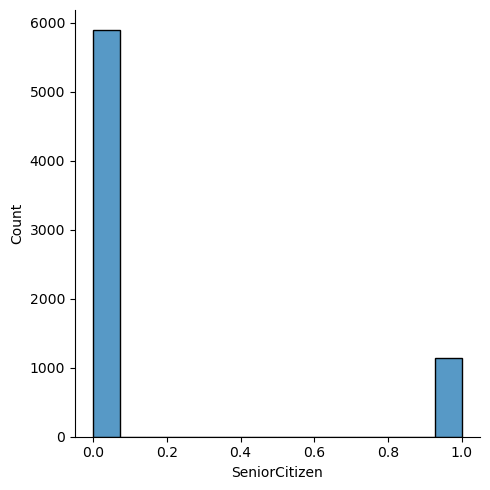

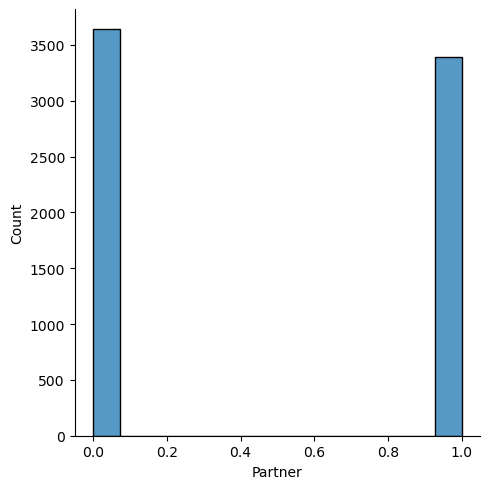

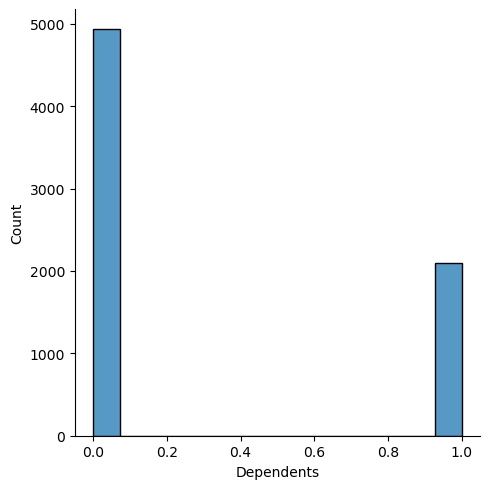

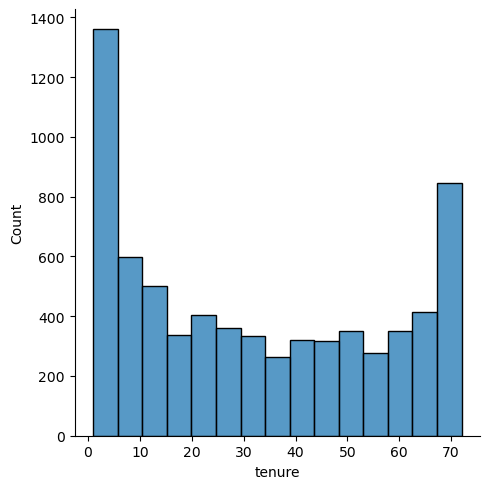

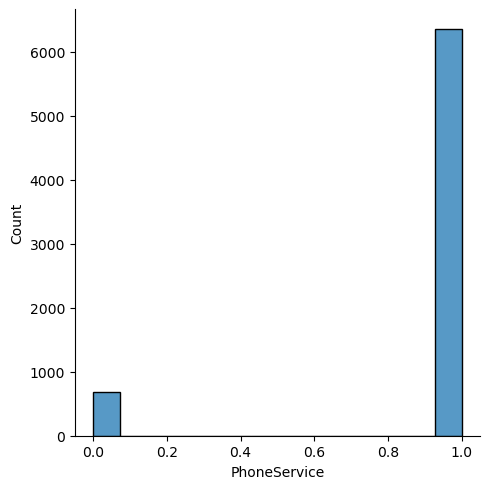

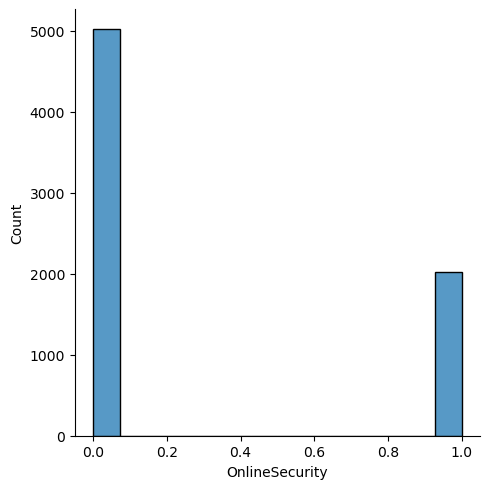

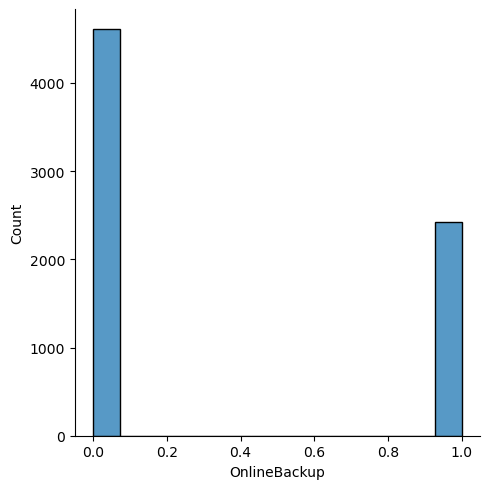

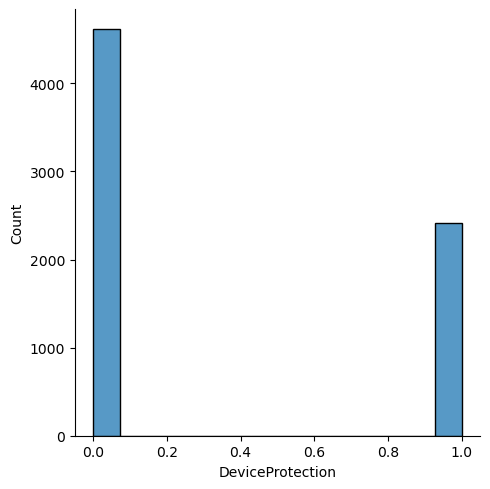

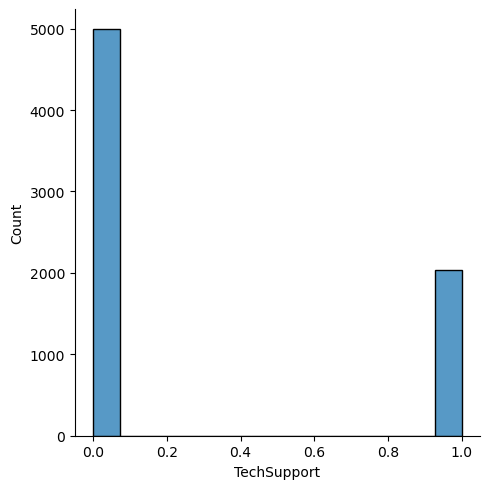

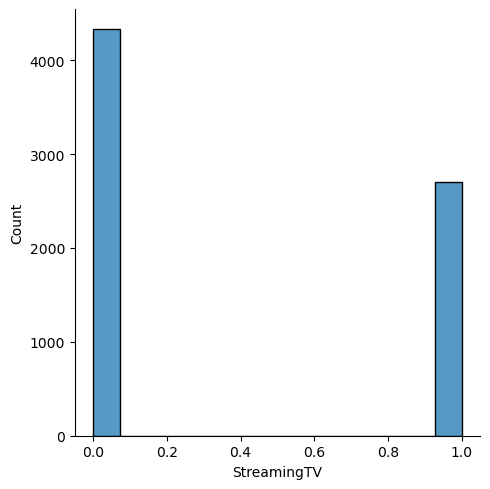

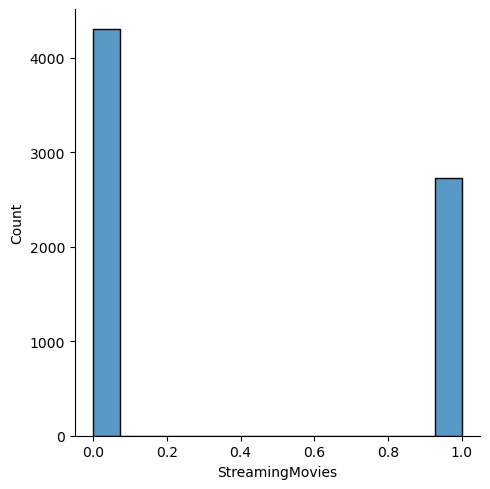

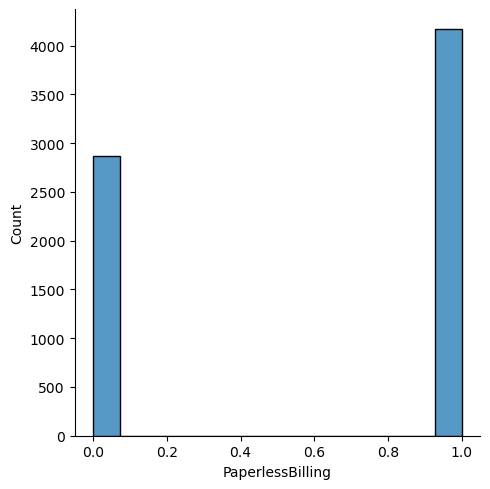

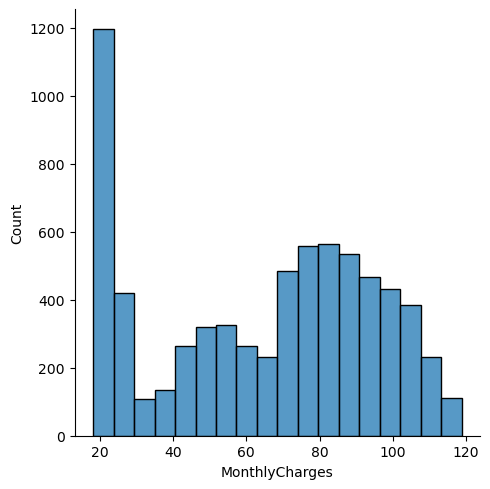

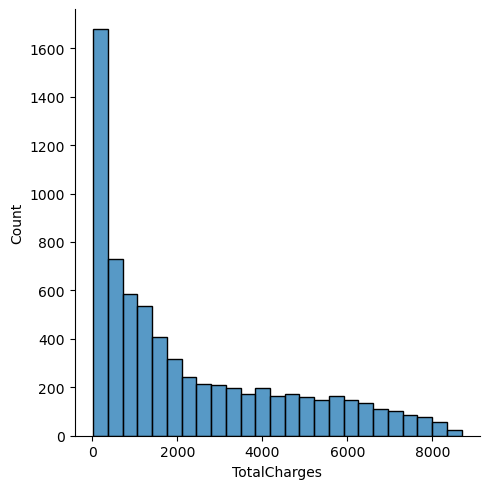

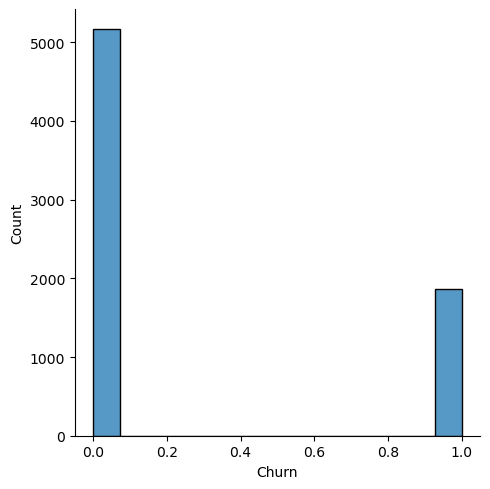

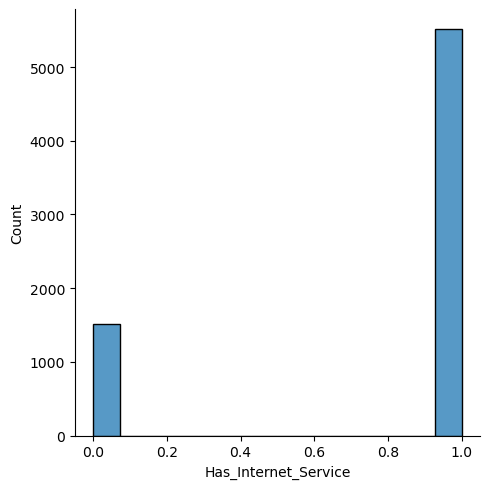

In [189]:
# Drop the customerID column
df1 = df.drop("customerID", axis=1)

# Plot the distribution of the numerical columns
num_cols = df1.select_dtypes(include=['float64', 'int64']).columns.tolist()
for col in num_cols:
    sns.displot(df1, x=col)

# Plot the distribution of the categorical columns
cat_cols = df1.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    sns.catplot(data=df1, x=col, kind='count')

# Show the plots
plt.show()

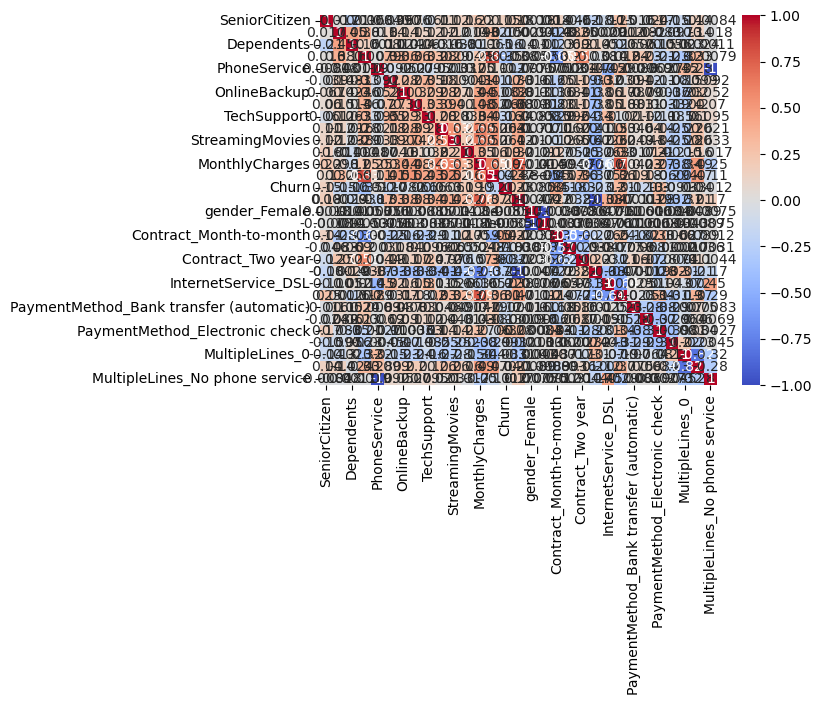

In [190]:
# Drop the customerID column
df1 = df.drop("customerID", axis=1)

# Compute the correlation matrix
corr_matrix = df1.corr()

# Plot the correlation matrix as a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Display the plot
plt.show()

In [191]:
df

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,Has_Internet_Service,gender_Female,gender_Male,Contract_Month-to-month,Contract_One year,Contract_Two year,InternetService_0,InternetService_DSL,InternetService_Fiber optic,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MultipleLines_0,MultipleLines_1,MultipleLines_No phone service
0,7590-VHVEG,0,1,0,1,0,0,1,0,0,0,0,1,29.85,29.85,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1
1,5575-GNVDE,0,0,0,34,1,1,0,1,0,0,0,0,56.95,1889.50,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0
2,3668-QPYBK,0,0,0,2,1,1,1,0,0,0,0,1,53.85,108.15,1,1,0,1,1,0,0,0,1,0,0,0,0,1,1,0,0
3,7795-CFOCW,0,0,0,45,0,1,0,1,1,0,0,0,42.30,1840.75,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1
4,9237-HQITU,0,0,0,2,1,0,0,0,0,0,0,1,70.70,151.65,1,1,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,0,1,1,24,1,1,0,1,1,1,1,1,84.80,1990.50,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0
7039,2234-XADUH,0,1,1,72,1,0,1,1,0,1,1,1,103.20,7362.90,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0
7040,4801-JZAZL,0,1,1,11,0,1,0,0,0,0,0,1,29.60,346.45,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1
7041,8361-LTMKD,1,1,0,4,1,0,0,0,0,0,0,1,74.40,306.60,1,1,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0


In [192]:
# Overall churn
df[df['Churn'] == 1].customerID.nunique() / df.customerID.nunique()

0.26578498293515357

In [193]:
# How many users over total dont have Internet service?
df[df['Has_Internet_Service'] == 0].customerID.nunique() / df.customerID.nunique()

0.2161547212741752

In [194]:
# do they churn more? no the other way around

print(round(df.loc[(df["InternetService"] == 'No') & (df["Churn"] == "Yes")].customerID.nunique() / df[df['InternetService'] == 'No'].customerID.nunique(), 2))


print(round(df.loc[(df["InternetService"] != 'No') & (df["Churn"] == "Yes")].customerID.nunique() / df[df['InternetService'] != 'No'].customerID.nunique(), 2))


KeyError: 'InternetService'

In [ ]:
# do we have weird cases in data: no
df[(df['InternetService'] == 'No') & (df['PhoneService'] == 'No')]

In [ ]:
df.customerID.nunique()